# Variational Autoencoder (VAE) dengan JAX dan Flax NNX

Tutorial ini menjelaskan cara mengimplementasikan **Variational Autoencoder (VAE)** menggunakan JAX dan Flax (dengan API NNX). VAE adalah salah satu model generatif paling populer yang menggabungkan prinsip *deep learning* dengan inferensi Bayes.

## Teori Variational Autoencoder

Berbeda dengan Autoencoder standar yang memetakan input ke dalam satu titik tetap di ruang laten, VAE memetakan input ke sebuah **distribusi probabilitas** di ruang laten. Hal ini memungkinkan kita untuk melakukan pengambilan sampel (*sampling*) dari ruang laten untuk menghasilkan data baru.

### 1. Evidence Lower Bound (ELBO)

Tujuan utama VAE adalah memaksimalkan kemungkinan (*likelihood*) dari data $p(\mathbf{x})$. Namun, karena menghitung $p(\mathbf{x})$ secara langsung sangat sulit (*intractable*), kita memaksimalkan batas bawah log-likelihood yang disebut **Evidence Lower Bound (ELBO)**:

$$\mathcal{L}(\theta, \phi; \mathbf{x}) = \mathbb{E}_{q_\phi(\mathbf{z}|\mathbf{x})} [\log p_\theta(\mathbf{x}|\mathbf{z})] - D_{KL}(q_\phi(\mathbf{z}|\mathbf{x}) || p(\mathbf{z}))$$

Dimana:
- $q_\phi(\mathbf{z}|\mathbf{x})$ adalah **Encoder** (model inferensi) yang memetakan data $\mathbf{x}$ ke distribusi laten $\mathbf{z}$.
- $p_\theta(\mathbf{x}|\mathbf{z})$ adalah **Decoder** (model generatif) yang merekonstruksi data $\mathbf{x}$ dari $\mathbf{z}$.
- $p(\mathbf{z})$ adalah *prior* dari ruang laten, biasanya diasumsikan sebagai distribusi Gauss standar $\mathcal{N}(0, I)$.
- Suku pertama adalah **Reconstruction Loss**, yang menjaga agar hasil rekonstruksi mirip dengan input.
- Suku kedua adalah **KL Divergence**, yang berfungsi sebagai regularisasi agar distribusi laten tidak menyimpang jauh dari *prior*.

### 2. Reparameterization Trick

Karena proses *sampling* $\mathbf{z} \sim q_\phi(\mathbf{z}|\mathbf{x})$ tidak memiliki turunan (*non-differentiable*), kita tidak bisa menggunakan *backpropagation* secara langsung. Untuk mengatasinya, kita menggunakan teknik **reparameterization**:

$$\mathbf{z} = \mu + \sigma \odot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)$$

Dengan cara ini, ketidakpastian (*stochasticity*) dipindahkan ke variabel eksternal $\epsilon$, sehingga kita tetap bisa menghitung gradien terhadap parameter $\mu$ dan $\sigma$.

### 3. Loss Function untuk Gaussian VAE

Jika kita mengasumsikan distribusi laten adalah Gaussian, maka KL Divergence dapat dihitung secara analitik:

$$D_{KL} = -\frac{1}{2} \sum_{j=1}^J (1 + \log(\sigma_j^2) - \mu_j^2 - \sigma_j^2)$$

Total loss yang diminimalkan dalam implementasi ini adalah:
$$\text{Loss} = \text{MSE}(\mathbf{x}, \hat{\mathbf{x}}) + \beta \cdot D_{KL}$$

## 1. Persiapan

Pertama, kita impor library yang dibutuhkan dan mendefinisikan konstanta yang akan digunakan.

In [20]:
import jax
import jax.numpy as jnp
from flax import nnx
import matplotlib.pyplot as plt
import sys, os
import numpy as np
import time as timer
from tqdm import tqdm
import grain.python as grain
from sklearn.datasets import fetch_openml
import optax

# Pastikan path ke viz_utils benar
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import viz_utils as vu
import model_utils as mu

import importlib
importlib.reload(mu)

# Konstanta
MODEL_DIR = "../models"
BATCH_SIZE = 128
NUM_EPOCH = 50
HIDDEN_SIZE = 40
BETA = 1
NVIZ = 64
nrow = np.floor(np.sqrt(NVIZ)).astype(int)

checkpoint_dir = os.path.join(MODEL_DIR, f"vae_mnist_z{HIDDEN_SIZE}")
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

sample_dir = os.path.join(checkpoint_dir, "samples_notebook")
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

## 2. Memuat Data (MNIST)

Kita menggunakan data MNIST dari OpenML. Data akan dinormalisasi ke rentang `[-1, 1]`.

In [8]:
print("Memuat data MNIST...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='liac-arff')
X_all, y_all = mnist.data, mnist.target.astype(np.int32)

X_train_all, X_test_all = X_all[:60000], X_all[60000:]
y_train_all, y_test_all = y_all[:60000], y_all[60000:]

class MNISTSource(grain.RandomAccessDataSource):
    def __init__(self, images, labels):
        self._images = images
        self._labels = labels
    def __len__(self):
        return len(self._images)
    def __getitem__(self, index):
        image = (self._images[index].reshape(1, 28, 28).astype(np.float32) / 255.0) * 2.0 - 1.0
        label = self._labels[index]
        return {'image': image, 'label': label}

def create_loader(data_source, batch_size, shuffle=False, seed=0):
    sampler = grain.IndexSampler(num_records=len(data_source), shard_options=grain.NoSharding(), shuffle=shuffle, num_epochs=1, seed=seed)
    dataloader = grain.DataLoader(data_source=data_source, sampler=sampler, worker_count=0)
    
    class BatchIterator:
        def __init__(self, loader, batch_size, num_records):
            self.loader, self.batch_size, self.num_records = loader, batch_size, num_records
        def __len__(self):
            return (self.num_records + self.batch_size - 1) // self.batch_size
        def __iter__(self):
            batch_images, batch_labels = [], []
            for record in self.loader:
                batch_images.append(record['image'])
                batch_labels.append(record['label'])
                if len(batch_images) == self.batch_size:
                    yield np.stack(batch_images), np.array(batch_labels)
                    batch_images, batch_labels = [], []
            if batch_images:
                 yield np.stack(batch_images), np.array(batch_labels)
    
    return BatchIterator(dataloader, batch_size, len(data_source))

train_loader = create_loader(MNISTSource(X_train_all, y_train_all), BATCH_SIZE, shuffle=True)
test_loader = create_loader(MNISTSource(X_test_all, y_test_all), BATCH_SIZE, shuffle=False)

Memuat data MNIST...


## 3. Arsitektur Model (VAE)

Model terdiri dari:
1.  **Encoder**: Mengubah gambar menjadi representasi laten (mu dan logvar).
2.  **Reparameterization**: Mengambil sampel dari distribusi laten.
3.  **Decoder**: Mengubah kode laten kembali menjadi gambar rekontruksi.

In [9]:
class VariationalAutoencoder(nnx.Module):
    def __init__(self, input_size, hidden_size, rngs: nnx.Rngs):
        self.hidden_size = hidden_size
        # Encoder: Linear -> Tanh -> Linear (outputs mu and logvar combined)
        self.encoder = nnx.Sequential(
            nnx.Linear(input_size, hidden_size ** 2, rngs=rngs),
            nnx.tanh,
            nnx.Linear(hidden_size ** 2, hidden_size * 2, rngs=rngs)
        )
        # Decoder: Linear -> Tanh -> Linear -> Tanh
        self.decoder = nnx.Sequential(
            nnx.Linear(hidden_size, hidden_size ** 2, rngs=rngs),
            nnx.tanh,
            nnx.Linear(hidden_size ** 2, input_size, rngs=rngs),
            nnx.tanh
        )

    def reparameterise(self, mu, logvar, rng):
        std = jnp.exp(0.5 * logvar)
        eps = jax.random.normal(rng, mu.shape)
        return mu + eps * std

    def encode(self, x, rng=None, train=True):
        mu_logvar = self.encoder(x).reshape(-1, 2, self.hidden_size)
        mu, logvar = mu_logvar[:, 0, :], mu_logvar[:, 1, :]
        if train and rng is not None:
            z = self.reparameterise(mu, logvar, rng)
        else:
            z = mu
        return z, mu, logvar

    def decode(self, z):
        return self.decoder(z)

    def __call__(self, x, rng=None, train=True):
        z, mu, logvar = self.encode(x, rng, train)
        return self.decode(z), mu, logvar

input_size = 28 * 28
rngs = nnx.Rngs(0)
model = VariationalAutoencoder(input_size, HIDDEN_SIZE, rngs=rngs)

## 4. Fungsi Loss dan Optimasi

Loss VAE adalah jumlah dari:
- **Reconstruction Loss** (MSE): Memastikan output mirip dengan input.
- **KL Divergence**: Regularisasi agar distribusi laten mendekati Gauss standar.

In [10]:
optimizer = nnx.Optimizer(model, optax.adam(3e-4), wrt=nnx.Param)
metrics = nnx.MultiMetric(
    total_loss=nnx.metrics.Average('total_loss'),
    rec_loss=nnx.metrics.Average('rec_loss'),
    kl_loss=nnx.metrics.Average('kl_loss'),
)

@nnx.jit
def train_step(model, optimizer, metrics, x, rng):
    def loss_fn(model):
        xr, mu, logvar = model(x, rng=rng, train=True)
        rec_loss = jnp.sum((xr - x)**2, axis=1)
        kl_loss = 0.5 * jnp.sum(jnp.square(mu) + jnp.exp(logvar) - logvar - 1, axis=1)
        total_loss = jnp.mean(rec_loss + BETA * kl_loss)
        return total_loss, (jnp.mean(rec_loss), jnp.mean(kl_loss))
    
    (loss, (rec_l, kl_l)), grads = nnx.value_and_grad(loss_fn, has_aux=True)(model)
    optimizer.update(model, grads)
    metrics.update(total_loss=loss, rec_loss=rec_l, kl_loss=kl_l)
    return loss

#### Tampilkan gambar input

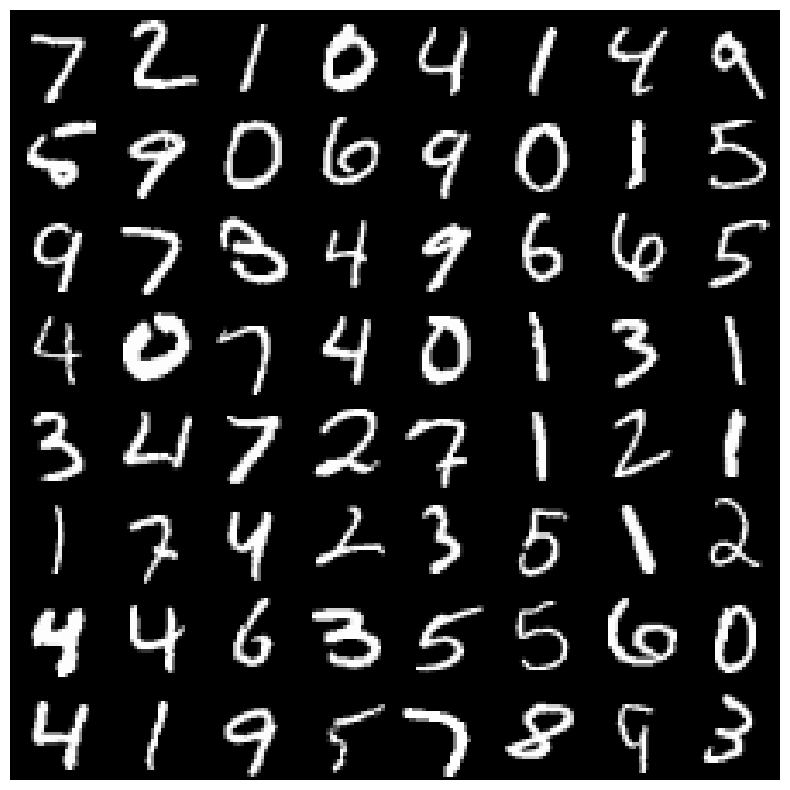

In [11]:
def get_fixed_samples(loader, n_viz):
    imgs, labels = [], []
    count = 0
    for batch_X, batch_y in loader:
        imgs.append(batch_X)
        labels.append(batch_y)
        count += batch_X.shape[0]
        if count >= n_viz: break
    return jnp.concatenate(imgs, axis=0)[:n_viz], jnp.concatenate(labels, axis=0)[:n_viz]

fixed_in_imgs, fixed_labels = get_fixed_samples(test_loader, NVIZ)

# Save real samples
grid_real = vu.set_grid(fixed_in_imgs, num_cells=NVIZ)
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(np.array(vu.normalize(grid_real, 0, 1)), (1, 2, 0)), cmap='gray')
plt.axis('off')
plt.savefig(os.path.join(sample_dir, 'real_samples.jpg'), bbox_inches='tight')
plt.show()
plt.close()

## 5. Pelatihan Model

Jalankan proses pelatihan selama beberapa epoch.

100%|██████████| 469/469 [00:04<00:00, 97.63batch/s, kl=39.58, rec=88.28, total_loss=127.86]  

Epoch 1/50 - Loss: 123.0000, Waktu: 4.82s
Model disimpan ke ../models/vae_mnist_z40/epoch_1.safetensors


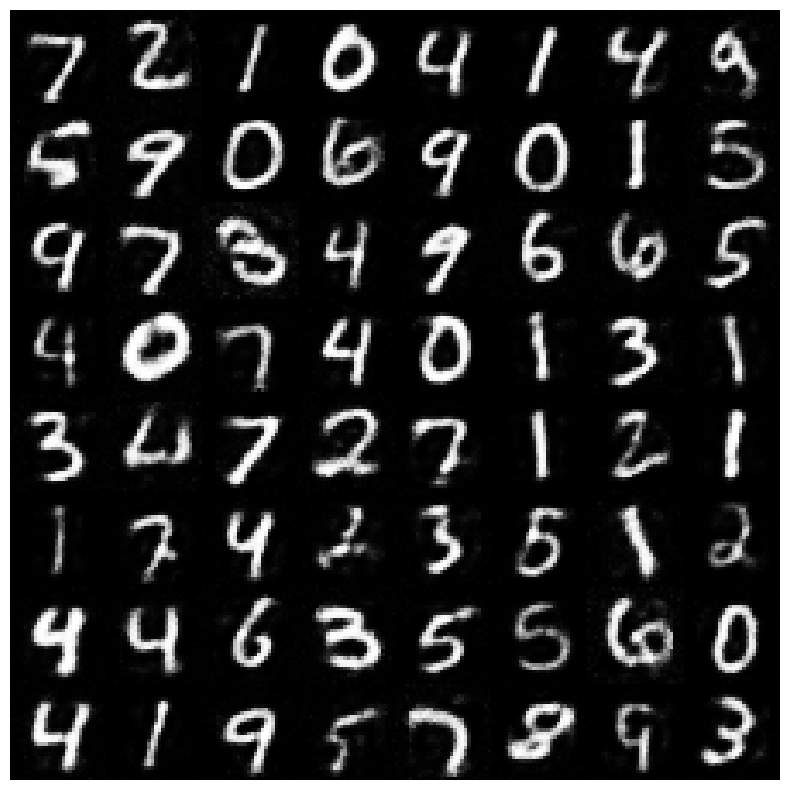

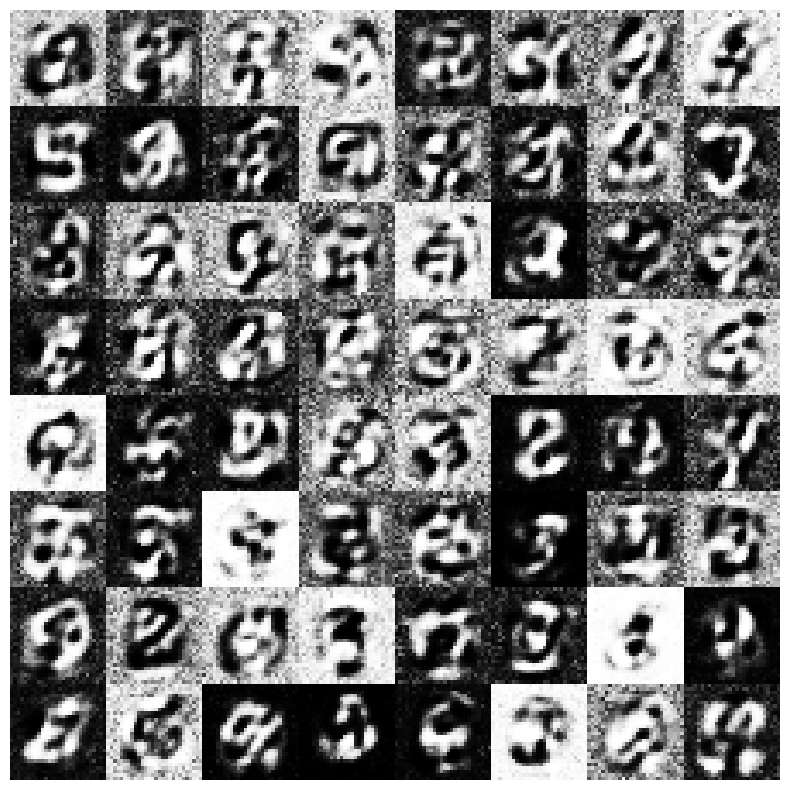

100%|██████████| 469/469 [00:04<00:00, 111.77batch/s, kl=42.59, rec=48.37, total_loss=90.95]


Epoch 2/50 - Loss: 90.6921, Waktu: 4.21s


100%|██████████| 469/469 [00:04<00:00, 116.51batch/s, kl=42.12, rec=45.34, total_loss=87.46]


Epoch 3/50 - Loss: 87.3003, Waktu: 4.04s


100%|██████████| 469/469 [00:04<00:00, 116.72batch/s, kl=41.37, rec=43.62, total_loss=84.98]


Epoch 4/50 - Loss: 84.8553, Waktu: 4.04s


100%|██████████| 469/469 [00:04<00:00, 113.83batch/s, kl=40.66, rec=42.30, total_loss=82.96]


Epoch 5/50 - Loss: 82.8316, Waktu: 4.14s


100%|██████████| 469/469 [00:03<00:00, 117.78batch/s, kl=39.92, rec=41.11, total_loss=81.02]


Epoch 6/50 - Loss: 80.9547, Waktu: 4.01s


100%|██████████| 469/469 [00:04<00:00, 116.77batch/s, kl=39.26, rec=40.16, total_loss=79.42]


Epoch 7/50 - Loss: 79.3721, Waktu: 4.04s


100%|██████████| 469/469 [00:04<00:00, 111.98batch/s, kl=38.71, rec=39.27, total_loss=77.99]


Epoch 8/50 - Loss: 77.9268, Waktu: 4.21s


100%|██████████| 469/469 [00:04<00:00, 116.02batch/s, kl=38.21, rec=38.67, total_loss=76.87]


Epoch 9/50 - Loss: 76.7878, Waktu: 4.07s


100%|██████████| 469/469 [00:04<00:00, 101.31batch/s, kl=37.65, rec=37.94, total_loss=75.59]


Epoch 10/50 - Loss: 75.5690, Waktu: 4.66s


100%|██████████| 469/469 [00:04<00:00, 112.57batch/s, kl=37.38, rec=37.44, total_loss=74.82]


Epoch 11/50 - Loss: 74.8290, Waktu: 4.20s
Model disimpan ke ../models/vae_mnist_z40/epoch_11.safetensors


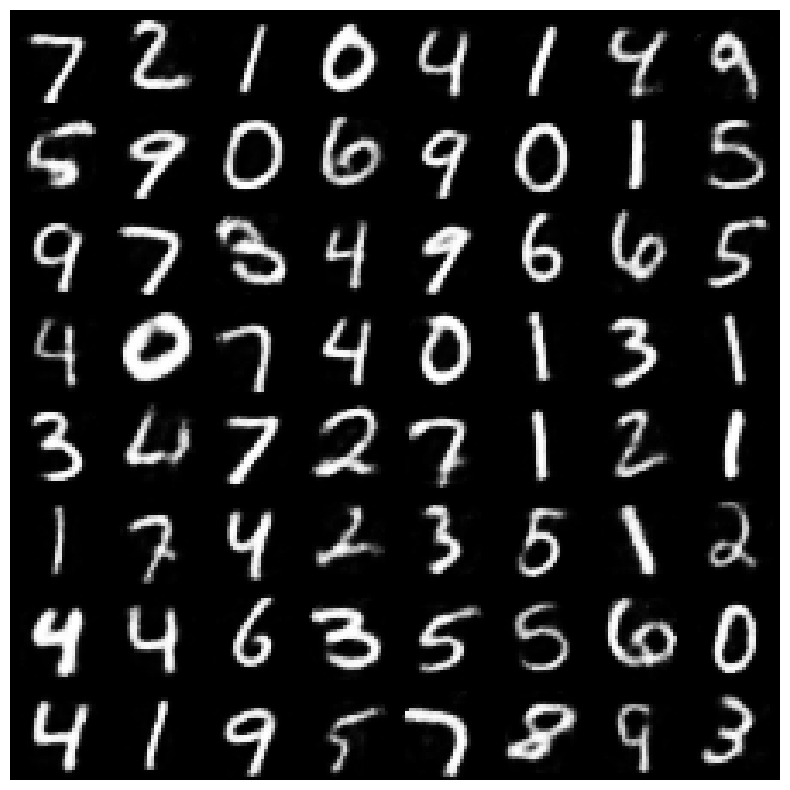

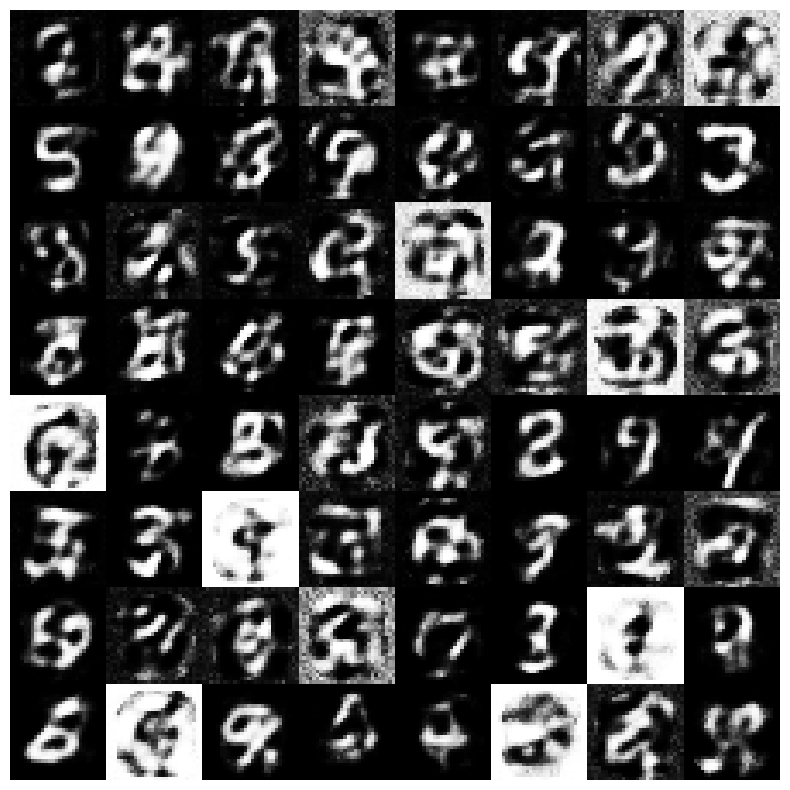

100%|██████████| 469/469 [00:04<00:00, 117.10batch/s, kl=36.98, rec=36.92, total_loss=73.89]


Epoch 12/50 - Loss: 73.8280, Waktu: 4.02s


100%|██████████| 469/469 [00:03<00:00, 117.49batch/s, kl=36.66, rec=36.47, total_loss=73.12]


Epoch 13/50 - Loss: 73.0986, Waktu: 4.01s


100%|██████████| 469/469 [00:04<00:00, 116.81batch/s, kl=36.41, rec=36.07, total_loss=72.48]


Epoch 14/50 - Loss: 72.4999, Waktu: 4.03s


100%|██████████| 469/469 [00:04<00:00, 116.16batch/s, kl=36.16, rec=35.72, total_loss=71.88]


Epoch 15/50 - Loss: 71.9180, Waktu: 4.05s


100%|██████████| 469/469 [00:04<00:00, 115.42batch/s, kl=36.03, rec=35.44, total_loss=71.47]


Epoch 16/50 - Loss: 71.4523, Waktu: 4.09s


100%|██████████| 469/469 [00:04<00:00, 113.93batch/s, kl=36.00, rec=35.19, total_loss=71.19]


Epoch 17/50 - Loss: 71.2066, Waktu: 4.13s


100%|██████████| 469/469 [00:03<00:00, 118.04batch/s, kl=35.75, rec=34.90, total_loss=70.64]


Epoch 18/50 - Loss: 70.6298, Waktu: 3.99s


100%|██████████| 469/469 [00:04<00:00, 110.24batch/s, kl=35.51, rec=34.62, total_loss=70.14]


Epoch 19/50 - Loss: 70.1412, Waktu: 4.28s


100%|██████████| 469/469 [00:04<00:00, 113.18batch/s, kl=35.35, rec=34.45, total_loss=69.80]


Epoch 20/50 - Loss: 69.7953, Waktu: 4.16s


100%|██████████| 469/469 [00:04<00:00, 115.71batch/s, kl=35.24, rec=34.15, total_loss=69.38]


Epoch 21/50 - Loss: 69.3815, Waktu: 4.08s
Model disimpan ke ../models/vae_mnist_z40/epoch_21.safetensors


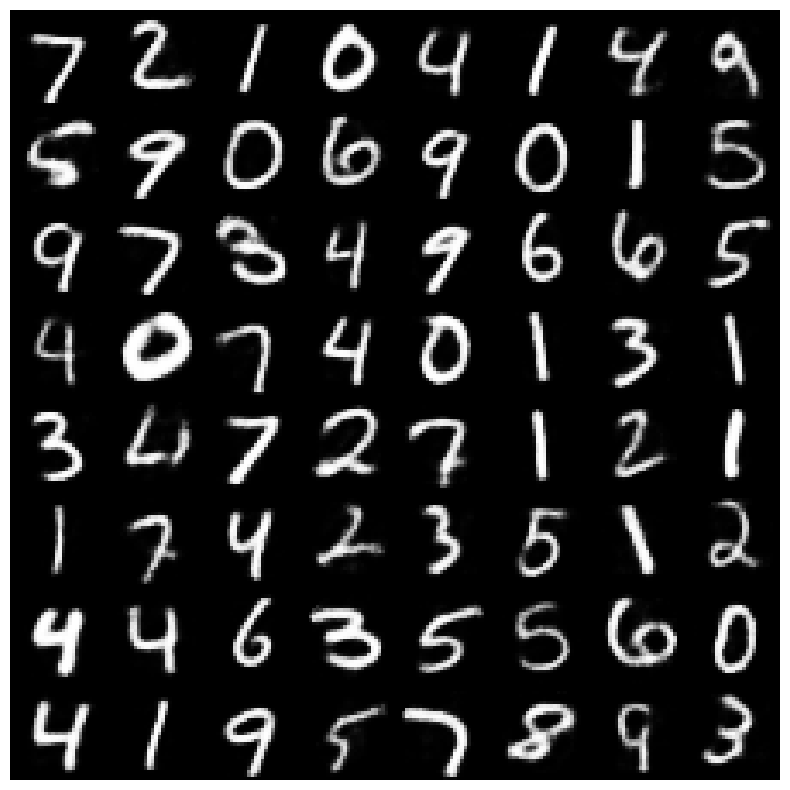

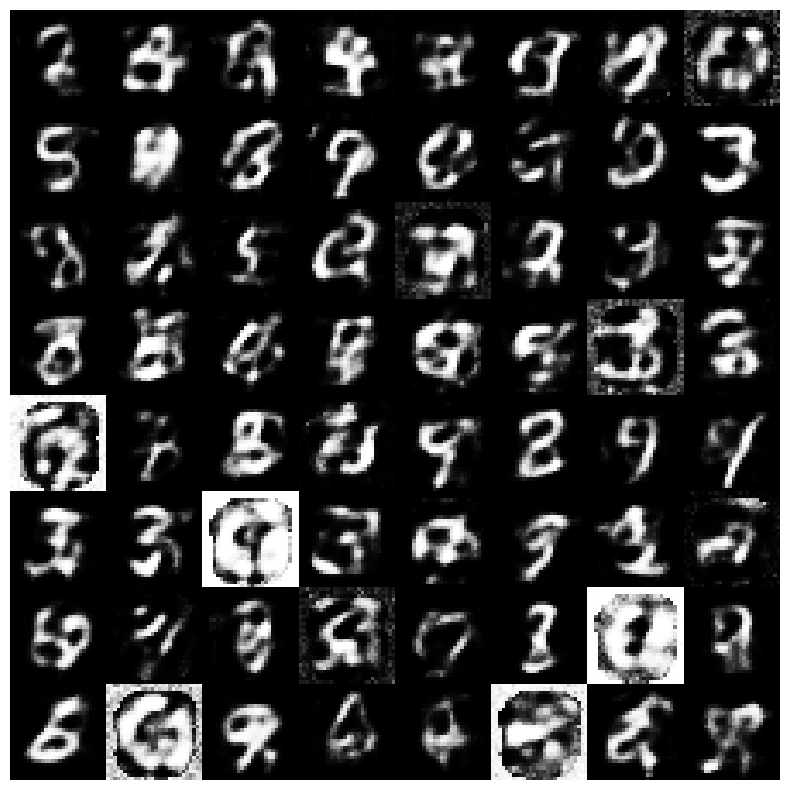

100%|██████████| 469/469 [00:04<00:00, 108.31batch/s, kl=35.12, rec=34.04, total_loss=69.16]


Epoch 22/50 - Loss: 69.1470, Waktu: 4.35s


100%|██████████| 469/469 [00:04<00:00, 104.48batch/s, kl=34.98, rec=33.85, total_loss=68.82]


Epoch 23/50 - Loss: 68.8611, Waktu: 4.52s


100%|██████████| 469/469 [00:04<00:00, 112.62batch/s, kl=34.94, rec=33.69, total_loss=68.63]


Epoch 24/50 - Loss: 68.6309, Waktu: 4.18s


100%|██████████| 469/469 [00:04<00:00, 115.03batch/s, kl=34.76, rec=33.48, total_loss=68.24]


Epoch 25/50 - Loss: 68.2591, Waktu: 4.09s


100%|██████████| 469/469 [00:04<00:00, 114.22batch/s, kl=34.70, rec=33.34, total_loss=68.03]


Epoch 26/50 - Loss: 68.0606, Waktu: 4.13s


100%|██████████| 469/469 [00:04<00:00, 114.87batch/s, kl=34.60, rec=33.20, total_loss=67.80]


Epoch 27/50 - Loss: 67.7944, Waktu: 4.10s


100%|██████████| 469/469 [00:04<00:00, 113.64batch/s, kl=34.53, rec=33.06, total_loss=67.58]


Epoch 28/50 - Loss: 67.6107, Waktu: 4.15s


100%|██████████| 469/469 [00:04<00:00, 100.39batch/s, kl=34.42, rec=32.92, total_loss=67.33]


Epoch 29/50 - Loss: 67.3740, Waktu: 4.69s


100%|██████████| 469/469 [00:04<00:00, 108.71batch/s, kl=34.36, rec=32.74, total_loss=67.11]


Epoch 30/50 - Loss: 67.1373, Waktu: 4.35s


100%|██████████| 469/469 [00:04<00:00, 112.02batch/s, kl=34.27, rec=32.66, total_loss=66.92]


Epoch 31/50 - Loss: 66.9567, Waktu: 4.21s
Model disimpan ke ../models/vae_mnist_z40/epoch_31.safetensors


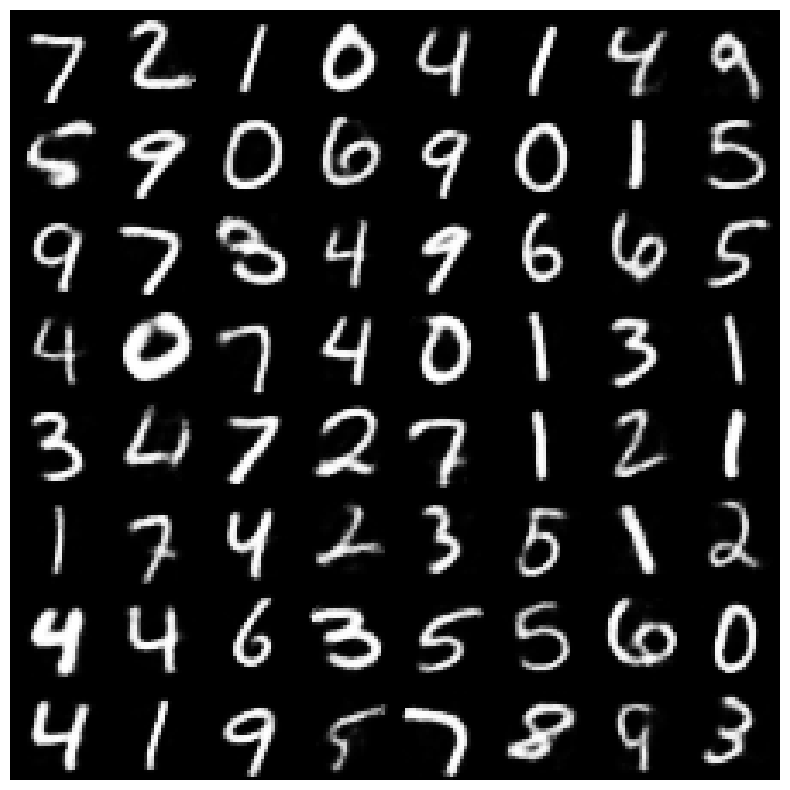

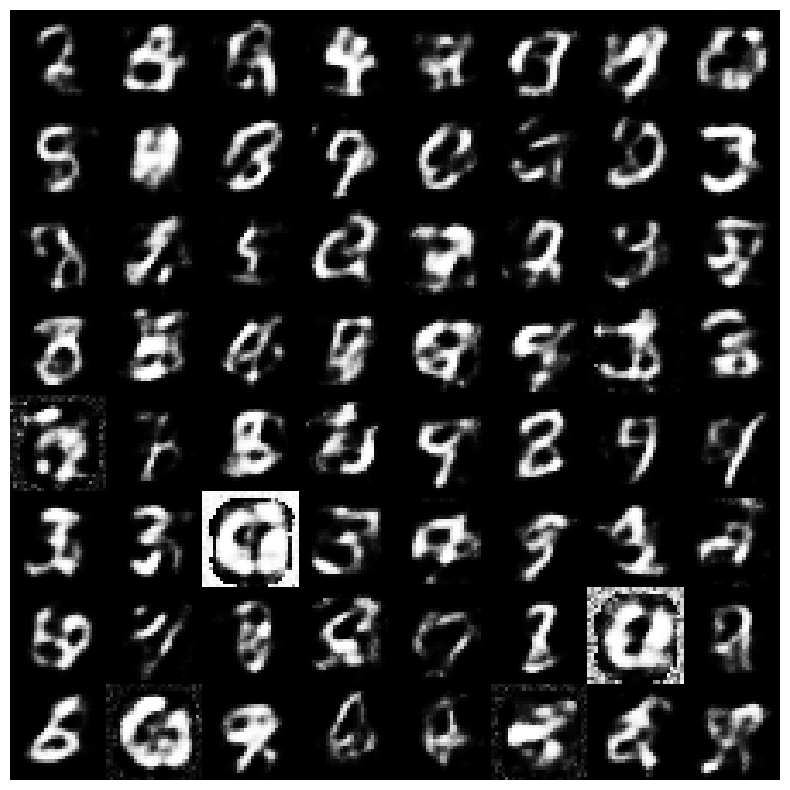

100%|██████████| 469/469 [00:04<00:00, 112.22batch/s, kl=34.17, rec=32.55, total_loss=66.73]


Epoch 32/50 - Loss: 66.7459, Waktu: 4.19s


100%|██████████| 469/469 [00:04<00:00, 113.44batch/s, kl=34.06, rec=32.42, total_loss=66.48]


Epoch 33/50 - Loss: 66.4988, Waktu: 4.16s


100%|██████████| 469/469 [00:04<00:00, 116.02batch/s, kl=34.04, rec=32.36, total_loss=66.40]


Epoch 34/50 - Loss: 66.4049, Waktu: 4.07s


100%|██████████| 469/469 [00:04<00:00, 116.94batch/s, kl=33.96, rec=32.25, total_loss=66.21]


Epoch 35/50 - Loss: 66.2252, Waktu: 4.06s


100%|██████████| 469/469 [00:04<00:00, 113.28batch/s, kl=33.92, rec=32.19, total_loss=66.11]


Epoch 36/50 - Loss: 66.1032, Waktu: 4.16s


100%|██████████| 469/469 [00:04<00:00, 114.01batch/s, kl=33.83, rec=32.05, total_loss=65.88]


Epoch 37/50 - Loss: 65.8805, Waktu: 4.14s


100%|██████████| 469/469 [00:03<00:00, 119.00batch/s, kl=33.76, rec=32.01, total_loss=65.78]


Epoch 38/50 - Loss: 65.7827, Waktu: 3.96s


100%|██████████| 469/469 [00:04<00:00, 114.40batch/s, kl=33.71, rec=31.89, total_loss=65.60]


Epoch 39/50 - Loss: 65.6185, Waktu: 4.12s


100%|██████████| 469/469 [00:03<00:00, 118.88batch/s, kl=33.60, rec=31.80, total_loss=65.40]


Epoch 40/50 - Loss: 65.4377, Waktu: 3.97s


100%|██████████| 469/469 [00:04<00:00, 116.28batch/s, kl=33.55, rec=31.72, total_loss=65.27]


Epoch 41/50 - Loss: 65.2996, Waktu: 4.06s
Model disimpan ke ../models/vae_mnist_z40/epoch_41.safetensors


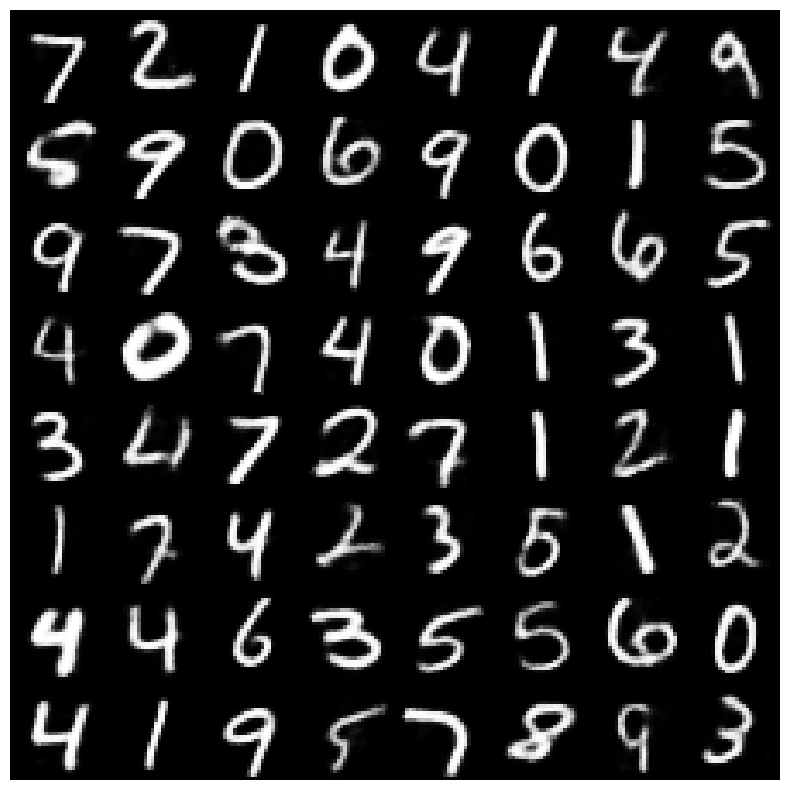

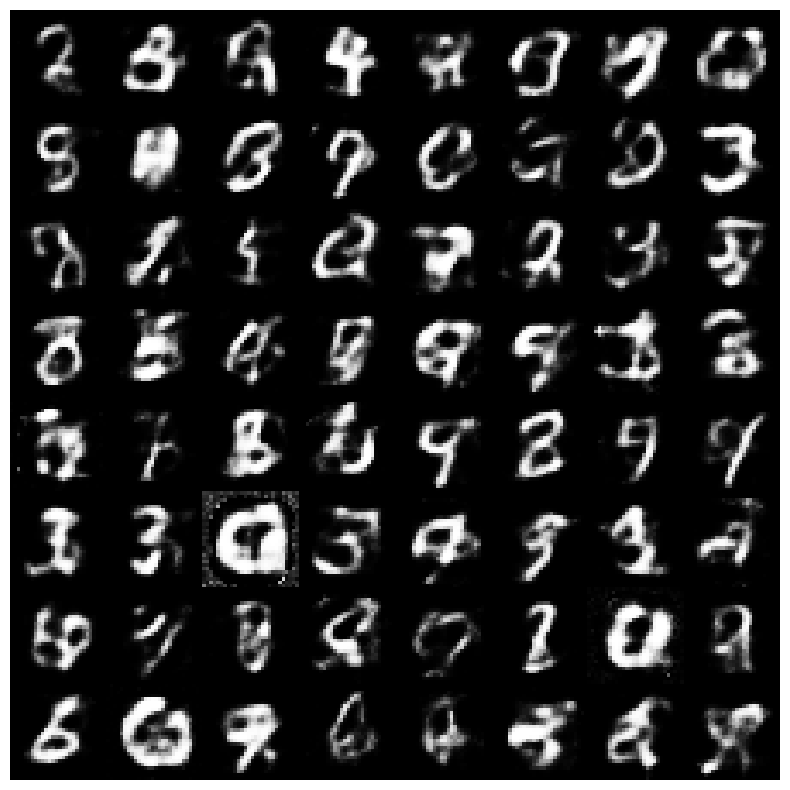

100%|██████████| 469/469 [00:04<00:00, 114.48batch/s, kl=33.49, rec=31.65, total_loss=65.14]


Epoch 42/50 - Loss: 65.1320, Waktu: 4.12s


100%|██████████| 469/469 [00:04<00:00, 115.13batch/s, kl=33.40, rec=31.57, total_loss=64.96]


Epoch 43/50 - Loss: 64.9889, Waktu: 4.09s


100%|██████████| 469/469 [00:03<00:00, 117.90batch/s, kl=33.34, rec=31.44, total_loss=64.78]


Epoch 44/50 - Loss: 64.8166, Waktu: 4.00s


100%|██████████| 469/469 [00:04<00:00, 116.94batch/s, kl=33.29, rec=31.39, total_loss=64.68]


Epoch 45/50 - Loss: 64.7084, Waktu: 4.03s


100%|██████████| 469/469 [00:04<00:00, 113.47batch/s, kl=33.21, rec=31.41, total_loss=64.61]


Epoch 46/50 - Loss: 64.6107, Waktu: 4.15s


100%|██████████| 469/469 [00:04<00:00, 116.14batch/s, kl=33.17, rec=31.26, total_loss=64.43]


Epoch 47/50 - Loss: 64.4540, Waktu: 4.05s


100%|██████████| 469/469 [00:04<00:00, 116.15batch/s, kl=33.13, rec=31.22, total_loss=64.35]


Epoch 48/50 - Loss: 64.3632, Waktu: 4.06s


100%|██████████| 469/469 [00:04<00:00, 114.69batch/s, kl=33.05, rec=31.15, total_loss=64.20]


Epoch 49/50 - Loss: 64.2164, Waktu: 4.11s


100%|██████████| 469/469 [00:04<00:00, 116.97batch/s, kl=32.98, rec=31.10, total_loss=64.08]

Epoch 50/50 - Loss: 64.1014, Waktu: 4.04s


In [12]:
def get_fixed_samples(loader, n_viz):
    imgs, labels = [], []
    count = 0
    for x, y in loader:
        imgs.append(x); labels.append(y)
        count += x.shape[0]
        if count >= n_viz: break
    return jnp.concatenate(imgs, axis=0)[:n_viz], jnp.concatenate(labels, axis=0)[:n_viz]

fixed_in_imgs, fixed_labels = get_fixed_samples(test_loader, NVIZ)
fixed_latent = jax.random.normal(jax.random.PRNGKey(42), (64, HIDDEN_SIZE))
step_rng = jax.random.PRNGKey(0)

for epoch in range(NUM_EPOCH):
    metrics.reset()
    start_t = timer.time()
    with tqdm(train_loader, unit="batch") as tepoch:
        for batch_idx, (X, y) in enumerate(tepoch):
            step_rng, sub_rng = jax.random.split(step_rng)
            train_step(model, optimizer, metrics, X.reshape(X.shape[0], -1), sub_rng)
            if batch_idx % 100 == 0:
                m = metrics.compute()
                tepoch.set_postfix(total_loss=f"{m['total_loss']:.2f}", rec=f"{m['rec_loss']:.2f}", kl=f"{m['kl_loss']:.2f}")
    
    m = metrics.compute()
    print(f"Epoch {epoch+1}/{NUM_EPOCH} - Loss: {m['total_loss']:.4f}, Waktu: {timer.time()-start_t:.2f}s")
    
    if epoch % 10 != 0:
        continue

    # Save checkpoint
    mu.save_checkpoint(model, epoch + 1, filedir=checkpoint_dir)
    
    # Visualization: Reconstruction
    fixed_in_flatten = fixed_in_imgs.reshape(fixed_in_imgs.shape[0], -1)
    # Use deterministic encoding for reconstruction visualization
    rec_imgs_flat, _, _ = model(fixed_in_flatten, train=False)
    rec_imgs = rec_imgs_flat.reshape(-1, 1, 28, 28)
    
    grid_rec = vu.set_grid(rec_imgs, num_cells=NVIZ)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(np.array(vu.normalize(grid_rec, 0, 1)), (1, 2, 0)), cmap='gray')
    plt.axis('off')
    plt.savefig(os.path.join(sample_dir, f'reconstructed_samples_{epoch}.jpg'), bbox_inches='tight')
    plt.show()
    plt.close()

    # Visualization: Random Generation
    gen_imgs_flat = model.decode(fixed_latent)
    gen_imgs = gen_imgs_flat.reshape(-1, 1, 28, 28)
    grid_gen = vu.set_grid(gen_imgs, num_cells=64)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(np.array(vu.normalize(grid_gen, 0, 1)), (1, 2, 0)), cmap='gray')
    plt.axis('off')
    plt.savefig(os.path.join(sample_dir, f'fixed_rec_{epoch}.jpg'), bbox_inches='tight')
    plt.show()
    plt.close()


## 6. Interpolasi Ruang Laten

Salah satu keunggulan VAE adalah kemampuannya untuk mempelajari representasi laten yang terstruktur dan kontinu. Kita dapat melakukan interpolasi antara dua titik di ruang laten untuk melihat transisi halus (*morphing*) dari satu objek ke objek lainnya.

In [21]:
# Load saved checkpoint
new_model = VariationalAutoencoder(input_size, HIDDEN_SIZE, rngs=nnx.Rngs(42))
checkpoint_path = f"{checkpoint_dir}/epoch_41.safetensors"
print(f"checkpoint_path: {checkpoint_path}")
mu.load_checkpoint(new_model, checkpoint_path)



checkpoint_path: ../models/vae_mnist_z40/epoch_41.safetensors
Model dimuat dari ../models/vae_mnist_z40/epoch_41.safetensors


In [22]:
import ipywidgets as widgets
from IPython.display import display

# Ambil dua sampel gambar dari test set
def show_interpolation(idx1, idx2, alpha):
    img1 = fixed_in_imgs[idx1].reshape(1, -1)
    img2 = fixed_in_imgs[idx2].reshape(1, -1)
    
    # Encode ke ruang laten (ambil mu untuk deterministik)
    _, z1, _ = new_model.encode(img1, train=False)
    _, z2, _ = new_model.encode(img2, train=False)
    
    # Interpolasi linear di ruang laten
    z_interp = (1 - alpha) * z1 + alpha * z2
    
    # Decode kembali ke gambar
    img_interp = new_model.decode(z_interp).reshape(1, 1, 28, 28)
    
    # Tampilkan hasil
    plt.figure(figsize=(10, 3))
    
    plt.subplot(1, 3, 1)
    plt.imshow(fixed_in_imgs[idx1].reshape(28, 28), cmap='gray')
    plt.title(f"Asal (Digit {fixed_labels[idx1]})")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(np.array(img_interp[0, 0]), cmap='gray')
    plt.title(f"Interpolasi (alpha={alpha:.2f})")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(fixed_in_imgs[idx2].reshape(28, 28), cmap='gray')
    plt.title(f"Tujuan (Digit {fixed_labels[idx2]})")
    plt.axis('off')
    
    plt.show()

# Setup Widget
alpha_slider = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.05, description='Alpha:')
idx1_slider = widgets.IntSlider(value=0, min=0, max=NVIZ-1, description='Indeks 1:')
idx2_slider = widgets.IntSlider(value=1, min=0, max=NVIZ-1, description='Indeks 2:')

widgets.interactive(show_interpolation, idx1=idx1_slider, idx2=idx2_slider, alpha=alpha_slider)

interactive(children=(IntSlider(value=0, description='Indeks 1:', max=63), IntSlider(value=1, description='Ind…